## Homework 06: Decision Trees

So far in this module, we have built a solid foundation in machine learning by focusing on linear regression and addressing a key challenge—the **model selection problem.** We have learned how to choose the right model, measure its performance, and fine-tune its parameters so that the model generalizes well to new data.

This week, we turn our attention to a fundamentally different model: **decision trees.** Unlike regression models, where we typically adjust at most one key parameter (for example, the degree of a polynomial), decision trees have many interacting parameters that can significantly affect performance. As we move from simpler models to more complex ones, it becomes essential to develop a **systematic workflow** for exploring the parameter space and optimizing model performance.

Next week, we will build on this foundation by studying **ensemble methods,** where multiple trees work together to produce even stronger predictive models. These methods will incorporate the parameters we explore this week, along with additional ones, offering even more flexibility in tuning but raising even more challenges in your workflow. 

### What We Will Do in This Homework

To identify the best set of parameters for a model with many adjustable settings, there are two main approaches. You can either iterate through the parameters **manually** or use **automated search tools** such as grid search or random search. However, both methods have drawbacks. Manual iteration can be (human) time-consuming, while automated searches can provide little insight and may not cover the most promising ranges and are (machine) time-consuming. Exhaustively searching a huge parameter space is often unrealistic.  

Rather than searching the entire parameter space, we aim to **narrow down** our grid search to ranges where the optimal model is most likely to be found. The goal is to **eliminate unlikely parameter values** while still  exploring regions of uncertainty.   

Plotting the MAE while only changing one of the parameters can yield important insights. Consider these plots:

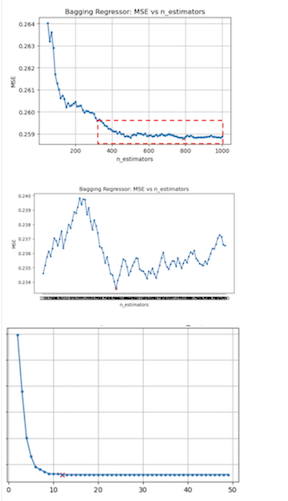

- In the first plot, there is a clear performance plateau, so searching outside the highlighted range is likely unnecessary.
- In the second plot, the best region is less obvious, so we should not eliminate any part of the space from consideration.
- In the third plot, clearly above a certain point, all values are equally good, so `None` (no restrictions on size) is probably the best choice. 


For these reasons, we will employ a two-phase strategy:

- **First Phase:** Visualize the effect of the most important parameters by plotting and calculating the minimal CV MAE scores. Adjust the range of the plots to understand how each parameter behaves on its own or in combination with closely related parameters. This phase provides valuable insights, especially in identifying regions where performance is unstable or sensitive to parameter changes.
- **Second Phase:** Focus on the most unstable parameter ranges identified in the first phase and perform an exhaustive search within these ranges to find the optimal model configuration.

The homework is divided into four problems. The first three problems cover the first phase, and the fourth problem addresses the second phase:

- **Problem One:** Tune the size and shape of the decision tree by adjusting `max_depth` and `max_leaf_nodes`.
- **Problem Two:** Explore how the `max_features` parameter can improve performance by effectively performing on-the-fly feature selection during node splits.
- **Problem Three:** Examine how `min_samples_split` influences performance by modifying the criteria for splitting nodes.
- **Problem Four:** Based on the insights gained, use `GridSearchCV` to zero in on the best parameter choices.

Before starting this homework, please review the lesson materials, watch the video, and download the decision tree notebook. This notebook contains code that you will refactor for this assignment—**refactoring existing code is an essential skill in machine learning.**

**Note: A Change from Our Previous Coding Examples:** 
- We will use repeated CV scoring with 5 repetitions and 5 folds. 
- We will use the **Mean Absolute Error (MAE)** instead of the Root Mean Square Error (RMSE) as our CV and testing metric. Both use the original units (dollars) but MAE is less sensitive to outliers. See Appendix One for a more detailed comparison. 

### Grading

This homework has nine (9) graded problems, each worth 5 points, and you get 5 points free if you complete the homework.  

In [1]:
# Useful imports
!pip install kagglehub --q
import numpy as np
import pandas as pd
import kagglehub

import os
import io
import requests
import zipfile
import time

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.tree            import DecisionTreeRegressor
from sklearn.metrics         import mean_absolute_error
from tqdm                    import tqdm

from scipy.stats import randint

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker           # Optional: you can print out y axis labels as dollars. 

# globals

random_seed = 42

# utility code

# Completely optional:  Format y-axis labels as dollars with commas
def dollar_format(x, pos):
    return f'${x:,.0f}'

def format_time(seconds):
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the Ames Housing Dataset  

The code cell below will load the dataset for you.  This is the same dataset we used for Homework 05. 

> **Notice** that this code includes a useful optimization: **before downloading, it first
checks whether the files already exist.** This is a essential step when working with large datasets or when building deep learning models, where training can span hours or even days. By reusing previously downloaded files or saved models, you can avoid unnecessary work and significantly speed up your workflow.

For a detailed description of the dataset features, please refer to the **Appendix** in Homework 05. 

In [2]:
data_dir = "Ames_Dataset"                              # Directory where files will be stored

# Check if one of the files exists; if not, download and extract the zip file

if not os.path.exists( os.path.join(data_dir, "X_train.csv") ):
    print("Dataset files not found. Downloading...")
    zip_url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/ames_housing.zip"
    try:
        response = requests.get(zip_url)
        response.raise_for_status()  # Raise an error for bad status codes
        # Extract the zip file into the designated directory
        with zipfile.ZipFile(io.BytesIO(response.content)) as zipf:
            zipf.extractall(data_dir)
        print("Files downloaded and extracted successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("Dataset files already exist. Skipping download.")

# Load the datasets
X_train = pd.read_csv(os.path.join(data_dir, "X_train.csv"))
X_test  = pd.read_csv(os.path.join(data_dir, "X_test.csv"))
y_train = pd.read_csv(os.path.join(data_dir, "y_train.csv")).squeeze("columns")    
y_test  = pd.read_csv(os.path.join(data_dir, "y_test.csv")).squeeze("columns")

print("Training and testing datasets loaded successfully.")


Dataset files already exist. Skipping download.
Training and testing datasets loaded successfully.


## Prelude: Wrapper Function for DecisionTreeRegressor

In the next cell, you'll find the code from the video notebook that wraps together the model, CV scoring, and tree visualization (though visualization is not used in this homework). We made a few minor modifications:

- Expanded the list of parameters to include the full set with default values.
- Employed `RepeatedKFold` to perform 5-fold CV repeated 5 times, yielding 25 MAE scores for averaging instead of just 5.
- Set the default value for `random_state` to `random_seed`.
- Set the default value for the `visualize` parameter to `False`.

In [3]:
# Already provided: the code for run_decision_tree_regressor from the video notebook for week 6 with changes as noted

repeated_cv = RepeatedKFold(n_repeats= 5,random_state=random_seed)    # This will perform 5-fold CV 5 times and return 25 floats instead of 5 as before
    
# Wrapper around DecisionTreeRegressor with repeated cross-validation and using MAE
def run_decision_tree_regressor(X_train,
                                y_train,
                                criterion                = 'absolute_error'  ,  # Default parameters for DecisionTreeRegressor
                                splitter                 = 'best',
                                max_depth                = None,
                                min_samples_split        = 2,
                                min_samples_leaf         = 1,
                                min_weight_fraction_leaf = 0.0,
                                max_features             = None,
                                random_state             = random_seed,               # Not the default, but we'll use it consistently for reproducibility
                                max_leaf_nodes           = None,
                                min_impurity_decrease    = 0.0,
                                ccp_alpha                = 0.0,     
                                n_jobs                   = -1,               # Additional parameters for CV and display of plot and results
                                visualize                = False
                               ): 
    
    # Initialize the DecisionTreeRegressor
    decision_tree_model = DecisionTreeRegressor(criterion                = criterion,
                                                splitter                 = splitter,
                                                max_depth                = max_depth,
                                                min_samples_split        = min_samples_split,
                                                min_samples_leaf         = min_samples_leaf,
                                                min_weight_fraction_leaf = min_weight_fraction_leaf,
                                                max_features             = max_features,
                                                random_state             = random_seed,
                                                max_leaf_nodes           = max_leaf_nodes,
                                                min_impurity_decrease    = min_impurity_decrease,
                                                ccp_alpha                = ccp_alpha
                                               )

    
    # Perform cross-validation and return mean CV MAE
    neg_MAE_scores = cross_val_score(decision_tree_model, 
                                     X_train, y_train,
                                     scoring='neg_mean_absolute_error',            
                                     cv=repeated_cv,
                                     n_jobs=n_jobs)

    mean_cv_MAE = -np.mean(neg_MAE_scores)  # Convert negative MAE back to positive

    # Train the model on the full training set for visualization purposes
    if visualize:
        decision_tree_model.fit(X_train, y_train)  # Train on full training data for visualization
        plt.figure(figsize=(12, 6))
        plot_tree(decision_tree_model, feature_names=feature_names, filled=True, rounded=True, precision=4)
        plt.title(f"Decision Tree Structure (max_depth={max_depth})")
        plt.show()

    return mean_cv_MAE
    

## Problem One: Controlling the Decision Tree's Shape with `max_depth` and `max_leaf_nodes`

In this problem, you will explore how the structure of a decision tree impacts its performance, using the cross-validated MAE as the evaluation metric. Answer the following questions:

**A.** How does the baseline model (with default parameters, except for `random_state=random_seed`) perform on the dataset?

**B.** When adjusting only the `max_depth` parameter, which depth produces the lowest CV MAE?

**C.** When adjusting only the `max_leaf_nodes` parameter, which value results in the best performance?

**D.** Can a combination of `max_depth` and `max_leaf_nodes` yield a lower CV MAE than optimizing either parameter independently?


### Part 1.A 

In the next cell, use `run_decision_tree_regressor` to establish a baseline CV MAE score for the **training set.** Keep all the parameters at their default, but set `random_state=random_seed`. 

Note: The `run_decision_tree_regressor` returns the MAE of the repeated CV score. 

In [4]:
# Your code here

baseline_cv_mae = run_decision_tree_regressor(X_train, y_train, random_state=random_seed)

### Problem 1.A Graded Answer

Set `a1a` to the baseline CV MAE score.

In [5]:
 # Your answer here; use an expression, not a constant derived by examining the data

a1a = baseline_cv_mae                     # replace 0 with an expression

In [6]:
# DO NOT change this cell in any way

print(f'a1a = ${a1a:,.2f}')

a1a = $25,472.84


### Part 1.B

In the next cell, adapt the code from the video notebook to plot CV MAE vs max_depth with the following modifications:

- Determine an appropriate range of `max_depth` values that zero in on the optimum. If the best value occurs at either end of your range, it indicates you may not have captured the true minimum—expand your range accordingly.
- Update your plot labels and printout to reflect that you are reporting the mean absolute error (MAE) in dollars. Use the following line in your plotting code to format the Y-axis labels in dollars:
  ```python
  plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
  ```

**Note:** The code in the video notebook may not always use default settings. For this experiment, ensure that all parameters except `max_depth` are set to their default values. 

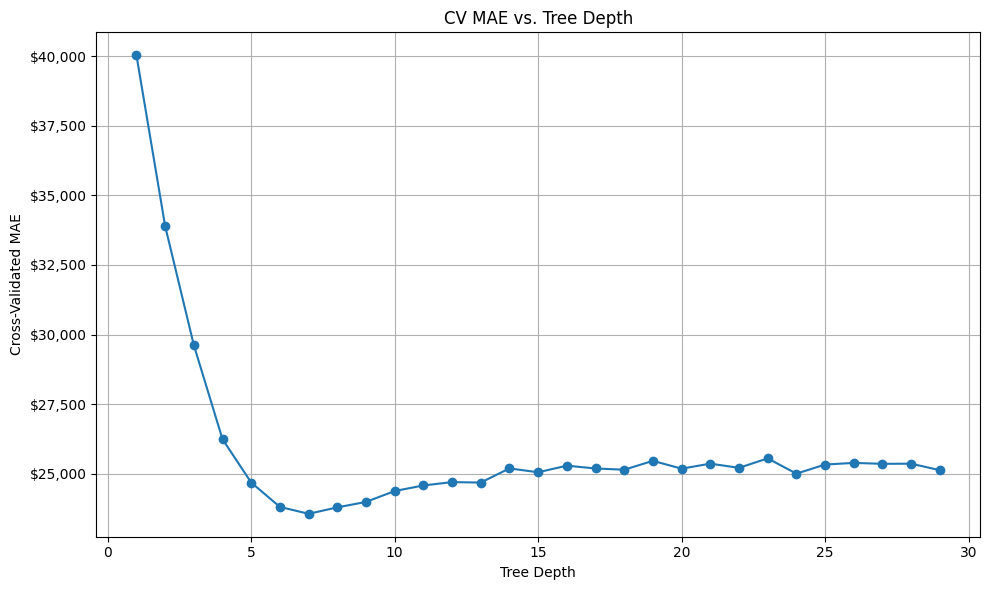

Best max_depth: 7, MAE: $23,564.53


In [7]:
# Cut and paste and modify the code from the video notebook as needed to plot and find the best max_depth

tree_depth_range = range(1, 30)

mae_scores = []

for depth in tree_depth_range:
    mae = run_decision_tree_regressor(X_train, y_train, max_depth=depth)
    mae_scores.append(mae)

# generate plot
plt.figure(figsize=(10,6))
plt.plot(tree_depth_range, mae_scores, marker='o')
plt.xlabel("Tree Depth")
plt.ylabel("Cross-Validated MAE")
plt.title("CV MAE vs. Tree Depth")
plt.grid(True)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

plt.tight_layout()
plt.show()

best_depth = tree_depth_range[np.argmin(mae_scores)]
best_mae = min(mae_scores)

print(f"Best max_depth: {best_depth}, MAE: ${best_mae:,.2f}")

### Problem 1.B Graded Answer

Set `a1b` to the depth found which results in the lowest CV MAE score.

In [8]:
# Your answer here; use an expression, not a constant derived by examining the data

a1b = best_depth                     # Replace 0 with an expression or a variable 

In [9]:
# DO NOT change this cell in any way

print(f'a1b = {a1b}')

a1b = 7


### Part 1.C

Now, perform the same experiment as in Part 1.B—but this time, focus on tuning the `max_leaf_nodes` parameter.

**Notes:**

- Ensure that `max_size` is set to `None` so that you can isolate the effect of `max_leaf_nodes` on limiting the size of the tree.
- The range of values for `max_leaf_nodes` will differ considerably from that used for `max_depth`. Experiment with a wide range until you find a minimum that does not occur at either end of your tested interval.

Remember to apply the same modifications as in Part 1.B, including updating your plot labels and printout to reflect that the metric is reported in dollars (using the line below to format the y-axis):

```python
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
```

After generating your plot and results, provide your answer for the graded question.

max_leaf_nodes=  2, MAE = $40,030.94
max_leaf_nodes=  7, MAE = $30,594.48
max_leaf_nodes= 12, MAE = $27,430.01
max_leaf_nodes= 17, MAE = $26,042.36
max_leaf_nodes= 22, MAE = $25,421.75
max_leaf_nodes= 27, MAE = $24,746.93
max_leaf_nodes= 32, MAE = $24,359.78
max_leaf_nodes= 37, MAE = $24,023.10
max_leaf_nodes= 42, MAE = $23,720.91
max_leaf_nodes= 47, MAE = $23,543.81
max_leaf_nodes= 52, MAE = $23,452.17
max_leaf_nodes= 57, MAE = $23,389.86
max_leaf_nodes= 62, MAE = $23,425.14
max_leaf_nodes= 67, MAE = $23,366.03
max_leaf_nodes= 72, MAE = $23,408.93
max_leaf_nodes= 77, MAE = $23,343.34
max_leaf_nodes= 82, MAE = $23,329.19
max_leaf_nodes= 87, MAE = $23,359.73
max_leaf_nodes= 92, MAE = $23,259.58
max_leaf_nodes= 97, MAE = $23,263.00
max_leaf_nodes=102, MAE = $23,334.71
max_leaf_nodes=107, MAE = $23,339.35
max_leaf_nodes=112, MAE = $23,346.50
max_leaf_nodes=117, MAE = $23,298.39
max_leaf_nodes=122, MAE = $23,293.07
max_leaf_nodes=127, MAE = $23,325.23
max_leaf_nodes=132, MAE = $23,373.62
m

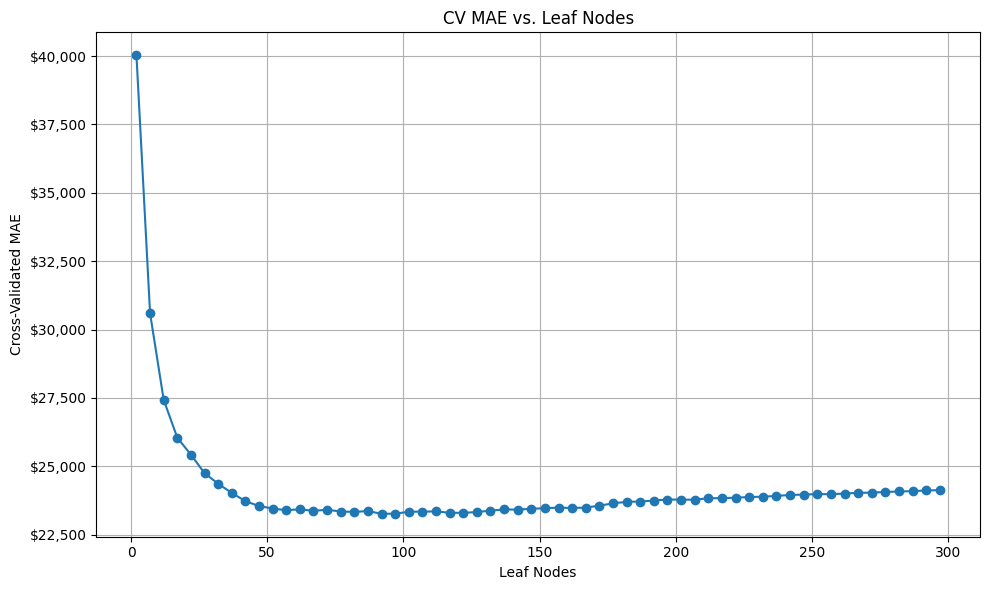


Best max_leaf_nodes: 92, MAE: $23,259.58


In [10]:
# Your code here

leaf_range = range(2, 301, 5)

mae_leaf_scores = []

for leaf_nodes in leaf_range:
    mae = run_decision_tree_regressor(
        X_train, y_train,
        max_leaf_nodes=leaf_nodes,
        max_depth=None
    )
    mae_leaf_scores.append(mae)
    print(f"max_leaf_nodes={leaf_nodes:3d}, MAE = ${mae:,.2f}")

# generate plot
plt.figure(figsize=(10,6))
plt.plot(leaf_range, mae_leaf_scores, marker='o')
plt.xlabel("Leaf Nodes")
plt.ylabel("Cross-Validated MAE")
plt.title("CV MAE vs. Leaf Nodes")
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.tight_layout()
plt.show()

# Best leaf node count
best_leaf = leaf_range[np.argmin(mae_leaf_scores)]
best_leaf_mae = min(mae_leaf_scores)
print(f"\nBest max_leaf_nodes: {best_leaf}, MAE: ${best_leaf_mae:,.2f}")

### Problem 1.C Graded Answer

Set `a1c` to the maximum number of leaf nodes that provided the best CV score.

In [11]:
# Your answer here; use an expression, not a constant derived by examining the data

a1c = best_leaf                  # Replace 0 with expression or variable 

In [12]:
# DO NOT change this cell in any way

print(f'a1c = {a1c}')

a1c = 92


### Part 1.D

Limiting the size of a decision tree using `max_depth` (depth) and `max_leaf_nodes` (width) affects the model in different ways. A natural question arises: is there a combination of these two parameters that yields a better score than tuning either one alone?


**What to Do:**

- In order to not disturb your original experiment, copy the code from Parts 1.B and 1.C as needed into new cells below, and go back and forth as needed, adjusting the ranges to see if you can "hone in" on the best combination of the two.
- Think about the strategy shown in the three plots at the beginning of the homework. 
- Keep in mind the possibility that the defaults may in one or the other case be the best choice!


### Solution: 

Redo 1.B (resulting in None) then see that the original result of 1.C is already optimal

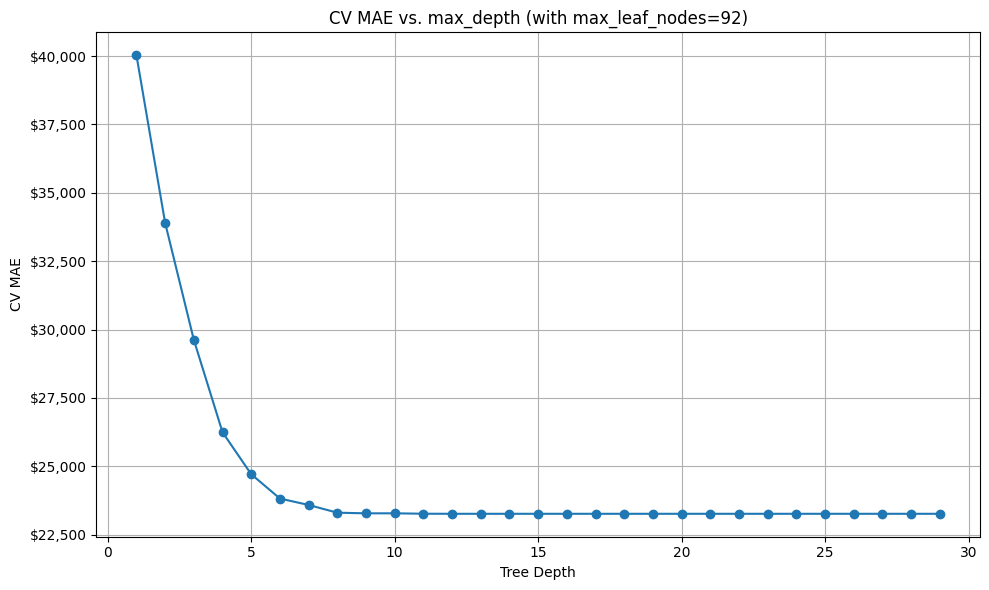

Best max_depth with max_leaf_nodes=92: 12, MAE = $23,259.58


In [13]:
# Cut and paste the code from the video notebook to plot and find the best max_depth
# TESTING finding max_depth where leaf_nodes is set - is depth better at none?

depth_range = range(1, 30)
mae_scores = []

for depth in depth_range:
    mae = run_decision_tree_regressor(
        X_train, y_train,
        max_depth=depth,
        max_leaf_nodes=92,  # optimal nodes from 1.C      
        random_state=random_seed
    )
    mae_scores.append(mae)

# generate plot
plt.figure(figsize=(10,6))
plt.plot(depth_range, mae_scores, marker='o')
plt.xlabel("Tree Depth")
plt.ylabel("CV MAE")
plt.title("CV MAE vs. max_depth (with max_leaf_nodes=92)")
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.tight_layout()
plt.show()

best_depth = depth_range[np.argmin(mae_scores)]
best_mae = min(mae_scores)
print(f"Best max_depth with max_leaf_nodes=92: {best_depth}, MAE = ${best_mae:,.2f}")

In [14]:
depth_range = range(5, 15)
leaf_range = range(70, 110, 5)

best_mae = float('inf')
best_params = (None, None)

for d in depth_range:
    for l in leaf_range:
        mae = run_decision_tree_regressor(
            X_train, y_train,
            max_depth=d,
            max_leaf_nodes=l,
            random_state=random_seed
        )
        print(f"depth={d}, leaf_nodes={l} - MAE=${mae:,.2f}")
        if mae < best_mae:
            best_mae = mae
            best_params = (d, l)

print(f"\nBest combo → max_depth={best_params[0]}, max_leaf_nodes={best_params[1]}, MAE=${best_mae:,.2f}")

depth=5, leaf_nodes=70 - MAE=$24,707.55
depth=5, leaf_nodes=75 - MAE=$24,707.55
depth=5, leaf_nodes=80 - MAE=$24,707.55
depth=5, leaf_nodes=85 - MAE=$24,707.55
depth=5, leaf_nodes=90 - MAE=$24,707.55
depth=5, leaf_nodes=95 - MAE=$24,707.55
depth=5, leaf_nodes=100 - MAE=$24,707.55
depth=5, leaf_nodes=105 - MAE=$24,707.55
depth=6, leaf_nodes=70 - MAE=$23,817.75
depth=6, leaf_nodes=75 - MAE=$23,817.75
depth=6, leaf_nodes=80 - MAE=$23,817.75
depth=6, leaf_nodes=85 - MAE=$23,817.75
depth=6, leaf_nodes=90 - MAE=$23,817.75
depth=6, leaf_nodes=95 - MAE=$23,817.75
depth=6, leaf_nodes=100 - MAE=$23,817.75
depth=6, leaf_nodes=105 - MAE=$23,817.75
depth=7, leaf_nodes=70 - MAE=$23,456.28
depth=7, leaf_nodes=75 - MAE=$23,532.32
depth=7, leaf_nodes=80 - MAE=$23,547.22
depth=7, leaf_nodes=85 - MAE=$23,534.47
depth=7, leaf_nodes=90 - MAE=$23,567.87
depth=7, leaf_nodes=95 - MAE=$23,608.27
depth=7, leaf_nodes=100 - MAE=$23,640.49
depth=7, leaf_nodes=105 - MAE=$23,631.39
depth=8, leaf_nodes=70 - MAE=$23,3

### Problem 1.D Graded Answer   

Set `a1d` to the tuple of the best max_depth and the best max_leaf_nodes parameters.

In [15]:
# Your answer here

# I was somewhat confused by this question. 
# Is it the best between 1B (7, None) or 1C (None, 92) because 1C resulted in a lower CV MAE, per the solution notes.
# But are we supposed to select an optimal search range for each based on the charting and then conduct a new search with two ranges, given they are independent of each other and together, they could yield different optimal values -- and if yes, I did find a slightly better combination this way, which was 12, 95 but also I realize that the with the steps I implemented may have still missed the global minimum.

a1d = None, 92                # Replace 0,0 with your answer

In [16]:
# DO NOT change this cell in any way

print(f'a1d = {a1d}')

a1d = (None, 92)


## Problem Two: Adding Feature Selection and Randomness with max_features

In this problem, you will build on the best model from Problem One by exploring the effect of the `max_features` parameter. This parameter does two key things:

- It performs variable selection at the level of each split by considering only a subset of features (we will revisit this idea in Week 9).
- It randomly chooses this subset at each split, encouraging the model to explore different parts of the feature space. This randomness can improve performance, especially when used with ensemble methods (which we will study next week).

What to Do:

- Use the best model from Problem One and vary only the `max_features` parameter.
- Experiment with a range of values from 10 up to the total number of features in the dataset.
- Print out the plot and the results, and answer the graded question as usual.
- Do not use `GridSearchCV` for this problem.
- Do not reset all parameters to their defaults; keep the best settings from Problem One and only change `max_features`.

max_features=10, MAE=$25,823.29
max_features=11, MAE=$25,460.86
max_features=12, MAE=$25,687.44
max_features=13, MAE=$24,760.01
max_features=14, MAE=$24,638.99
max_features=15, MAE=$24,972.69
max_features=16, MAE=$24,901.49
max_features=17, MAE=$24,512.67
max_features=18, MAE=$24,913.35
max_features=19, MAE=$24,823.46
max_features=20, MAE=$24,209.18
max_features=21, MAE=$25,030.27
max_features=22, MAE=$24,792.58
max_features=23, MAE=$24,050.93
max_features=24, MAE=$23,938.78
max_features=25, MAE=$24,110.63
max_features=26, MAE=$23,745.46
max_features=27, MAE=$24,039.57
max_features=28, MAE=$24,071.83
max_features=29, MAE=$23,794.54
max_features=30, MAE=$24,021.25
max_features=31, MAE=$23,878.06
max_features=32, MAE=$23,878.47
max_features=33, MAE=$23,641.60
max_features=34, MAE=$23,541.57
max_features=35, MAE=$23,798.26
max_features=36, MAE=$23,675.00
max_features=37, MAE=$23,977.30
max_features=38, MAE=$23,651.26
max_features=39, MAE=$23,960.22
max_features=40, MAE=$23,761.34
max_feat

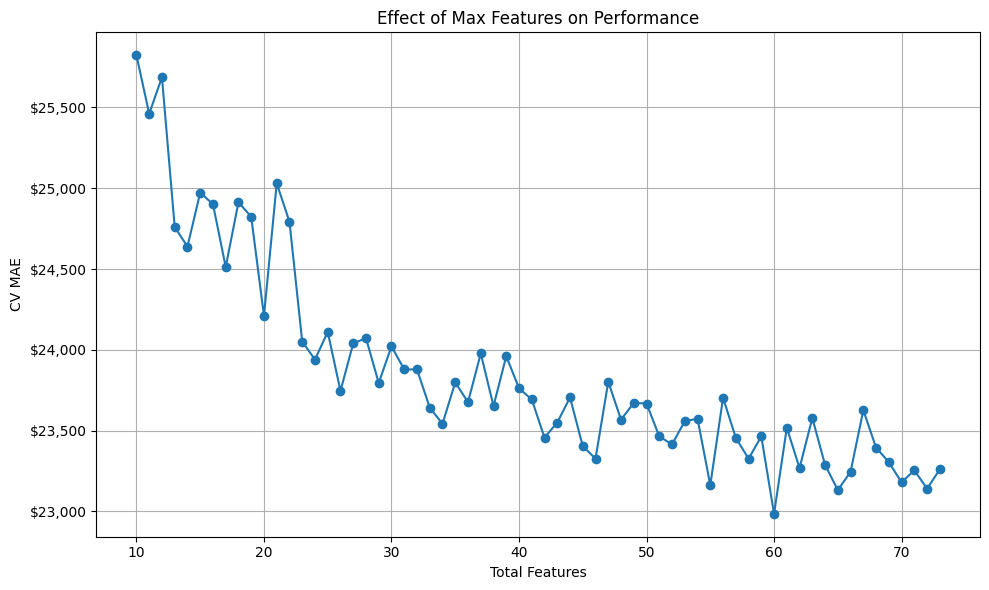


Best max_features = 60, MAE = $22,984.45


In [17]:
# Your code here

feature_range = range(10, X_train.shape[1] + 1)

mae_feature_scores = []

for maxf in feature_range:
    mae = run_decision_tree_regressor(
        X_train, y_train,
        max_depth=None,
        max_leaf_nodes=92,
        max_features=maxf,
        random_state=random_seed
    )
    mae_feature_scores.append(mae)
    print(f"max_features={maxf}, MAE=${mae:,.2f}")

# generate plot
plt.figure(figsize=(10,6))
plt.plot(feature_range, mae_feature_scores, marker='o')
plt.xlabel("Total Features")
plt.ylabel("CV MAE")
plt.title("Effect of Max Features on Performance")
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.tight_layout()
plt.show()

best_maxf = feature_range[np.argmin(mae_feature_scores)]
best_mf_mae = min(mae_feature_scores)
print(f"\nBest max_features = {best_maxf}, MAE = ${best_mf_mae:,.2f}")

### Problem 2 Graded Answer

This may or may not have improved the score.  In any case, set `a2` to the best parameter choice, remembering that `None` 
is the same as the maximum value. 

In [18]:
# Your answer here

a2 = best_maxf                    # Replace 0 with an expression or a variable   

In [19]:
# DO NOT change this cell in any way

print(f'a2 = {a2}')

a2 = 60


## Problem Three: Controlling Node Splitting with min_samples_split

In this problem, you will investigate how the min_samples_split parameter affects your decision tree’s performance. Using the best model configuration obtained from Problems One **and Two,** vary only the `min_samples_split` parameter while keeping all other parameters fixed.

**What to Do:**

- As before, experiment with different values of `min_samples_split`, starting with a lower bound of 2.
- Plot the CV MAE against the different values of `min_samples_split` and print out your results.
- Do not use `GridSearchCV` for this experiment.
- Make sure that only the `min_samples_split` parameter is varied; all other parameters should remain at the best settings you’ve found so far.
- Finally, answer the graded question based on your findings.
 

min_samples_split=2, MAE=$22,984.45
min_samples_split=3, MAE=$22,833.07
min_samples_split=4, MAE=$23,114.84
min_samples_split=5, MAE=$23,145.75
min_samples_split=6, MAE=$23,138.79
min_samples_split=7, MAE=$23,135.60
min_samples_split=8, MAE=$23,167.76
min_samples_split=9, MAE=$23,168.08
min_samples_split=10, MAE=$23,111.81
min_samples_split=11, MAE=$23,067.80
min_samples_split=12, MAE=$23,070.16
min_samples_split=13, MAE=$23,139.12
min_samples_split=14, MAE=$23,136.34
min_samples_split=15, MAE=$23,100.23
min_samples_split=16, MAE=$23,025.44
min_samples_split=17, MAE=$23,018.61
min_samples_split=18, MAE=$23,068.57
min_samples_split=19, MAE=$22,996.88
min_samples_split=20, MAE=$23,183.22
min_samples_split=21, MAE=$22,899.57
min_samples_split=22, MAE=$22,909.39
min_samples_split=23, MAE=$23,001.80
min_samples_split=24, MAE=$22,890.15
min_samples_split=25, MAE=$22,945.60
min_samples_split=26, MAE=$23,021.16
min_samples_split=27, MAE=$23,006.00
min_samples_split=28, MAE=$22,918.96
min_sampl

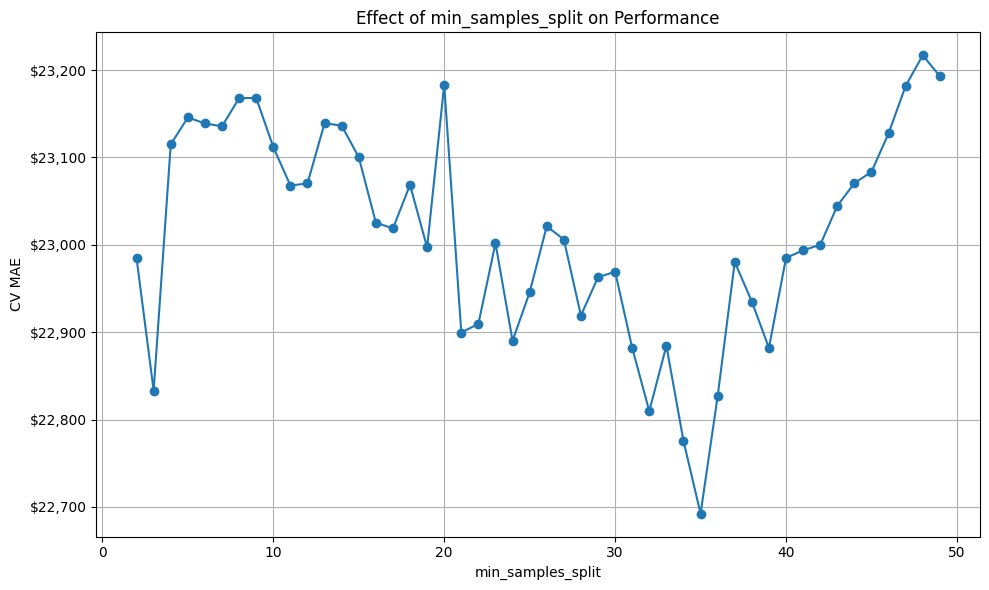


Best min_samples_split = 35, MAE = $22,692.24


In [20]:
# Your code here

split_range = range(2,50)
mae_split_scores = []

for minsplit in split_range:
    mae = run_decision_tree_regressor(
        X_train, y_train,
        max_depth=None,
        max_leaf_nodes=92,
        max_features=60, 
        min_samples_split=minsplit,
        random_state=random_seed
    )

    mae_split_scores.append(mae)
    print(f"min_samples_split={minsplit}, MAE=${mae:,.2f}")

# generate plot
plt.figure(figsize=(10,6))
plt.plot(split_range, mae_split_scores, marker='o')
plt.xlabel("min_samples_split")
plt.ylabel("CV MAE")
plt.title("Effect of min_samples_split on Performance")
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.tight_layout()
plt.show()

best_split = split_range[np.argmin(mae_split_scores)]
best_split_mae = min(mae_split_scores)
print(f"\nBest min_samples_split = {best_split}, MAE = ${best_split_mae:,.2f}")

### Problem 3 Graded Answer

Again, this may or may not have found a lower CV score. 

Assign `a3` to the best choice for the minimum number of samples to perform a split. 

In [21]:
# Your answer here; use an expression, not a constant derived by examining the data

a3 = best_split                    # Replace 0 with an expression or a variable 

In [22]:
# DO NOT change this cell in any way

print(f'a3 = {a3}')

a3 = 35


## **Problem Four: Fine-Tuning Your Model with Grid Search**

Now that we have a solid understanding of how our parameters influence model performance, it’s time to refine our search. Instead of testing large parameter ranges blindly, we will **use insights from previous experiments** to focus on the most promising values—balancing accuracy with computational efficiency.

### **What to Do**
- Using insights from **Problems One through Three**, select **refined parameter ranges** for the three key parameters.
- Perform a **grid search** over these restricted ranges.
    - Be sure to include this among the parameters to `param_grid`:
>  `'criterion': ["absolute_error"]`
    - Be sure to include repeated CV scoring in the parameter to `GridSearchCV`:
> `cv=repeated_cv`
- Print out the **top 10 results**. 
- Answer the graded questions.

**Note: Grid search is a compute hog!**  Start with modest ranges around your best values, and see what happens. Running a large set of ranges will almost always take way too long!

In [23]:
# Your code here

param_grid = {
    'max_leaf_nodes': [85, 90, 92, 95, 100],
    'max_features': [55, 60, 65],
    'min_samples_split': [30, 35, 40],
    'criterion': ['absolute_error']
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=random_seed),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=repeated_cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

gridsearch_results = pd.DataFrame(grid_search.cv_results_)
top10 = gridsearch_results[['mean_test_score', 'params']].copy()
top10['mean_test_score'] = -top10['mean_test_score']
top10 = top10.sort_values(by='mean_test_score').head(10)
print(top10)

Fitting 25 folds for each of 45 candidates, totalling 1125 fits
    mean_test_score                                             params
28     22667.374587  {'criterion': 'absolute_error', 'max_features'...
25     22683.077090  {'criterion': 'absolute_error', 'max_features'...
22     22692.241408  {'criterion': 'absolute_error', 'max_features'...
19     22696.405785  {'criterion': 'absolute_error', 'max_features'...
16     22699.612151  {'criterion': 'absolute_error', 'max_features'...
36     22955.634530  {'criterion': 'absolute_error', 'max_features'...
40     22957.748917  {'criterion': 'absolute_error', 'max_features'...
33     22960.225520  {'criterion': 'absolute_error', 'max_features'...
34     22960.764990  {'criterion': 'absolute_error', 'max_features'...
26     22961.588711  {'criterion': 'absolute_error', 'max_features'...


In [24]:
best_params = grid_search.best_params_
best_mae = -grid_search.best_score_ 

print(f"Best parameters: {best_params}")
print(f"Best CV MAE: ${best_mae:,.2f}")

Best parameters: {'criterion': 'absolute_error', 'max_features': 60, 'max_leaf_nodes': 100, 'min_samples_split': 35}
Best CV MAE: $22,667.37


In [25]:
# # Your code here

# VERIFYING max_depth is optimal at none and it is lol :)

param_grid = {
    'max_depth': [None, 6, 7, 8],
    'max_leaf_nodes': [100],
    'max_features': [60],
    'min_samples_split': [35],
    'criterion': ['absolute_error']
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=random_seed),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=repeated_cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

gridsearch_results = pd.DataFrame(grid_search.cv_results_)
top10 = gridsearch_results[['mean_test_score', 'params']].copy()
top10['mean_test_score'] = -top10['mean_test_score']
top10 = top10.sort_values(by='mean_test_score').head(10)
print(top10)

Fitting 25 folds for each of 4 candidates, totalling 100 fits
   mean_test_score                                             params
0     22667.374587  {'criterion': 'absolute_error', 'max_depth': N...
3     22722.940841  {'criterion': 'absolute_error', 'max_depth': 8...
2     23105.761670  {'criterion': 'absolute_error', 'max_depth': 7...
1     23490.462949  {'criterion': 'absolute_error', 'max_depth': 6...


In [26]:
best_params = grid_search.best_params_
best_mae = -grid_search.best_score_ 

print(f"Best parameters: {best_params}")
print(f"Best CV MAE: ${best_mae:,.2f}")

Best parameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 60, 'max_leaf_nodes': 100, 'min_samples_split': 35}
Best CV MAE: $22,667.37


### Problem 4 Graded Answers

Set `a4a` to a tuple of the four optimal parameter values found.

In [27]:
# Your answer here

a4a = None, 100, 60, 35          # Your answer should be a tuple ( best max_depth, best max_leaf_nodes, best max_features, best min_samples_split)

In [28]:
# DO NOT change this cell in any way

print(f'a4a = {a4a}')

a4a = (None, 100, 60, 35)


Set `a4b` to the best MAE score found.

In [29]:
# Your answer here

a4b = best_mae                     # Cut and paste from the gridsearch listing

In [30]:
# DO NOT change this cell in any way

print(f'a4b = ${a4b:,.2f}')

a4b = $22,667.37


### Final Exam Time!

Run your best model through the test set using `run_decision_tree_regressor` and report the test score. 

In [31]:
# Your code here

best_model = DecisionTreeRegressor(
    max_depth=None,
    max_leaf_nodes=100,
    max_features=60,
    min_samples_split=35,
    criterion='absolute_error',
    random_state=random_seed
)

# fit on best
best_model.fit(X_train, y_train)

# test predict
y_pred = best_model.predict(X_test)

# test mae 
a4c = mean_absolute_error(y_test, y_pred)

In [32]:
# Your answer here

a4c = a4c             # Replace with the test MAE

In [33]:
# DO NOT change this cell in any way

print(f'a4c = ${a4c:,.2f}')

a4c = $22,618.87


## Appendix One: Root Mean Square Error or Mean Absolute Error?

### RMSE vs. MAE for a Decision-Tree Regressor on *Ames Housing*


| Metric | How it treats errors | When it’s a good fit | Practical notes for **Ames Housing** |
|--------|---------------------|----------------------|---------------------------------------|
| **RMSE**  ($\sqrt{\text{MSE}}$) | Squares errors before averaging → **large mistakes dominate** | • Punishes big misses (e.g., overpricing a home by \$100 k) <br>• Standard metric in ML competitions and much theoretical work | Ames has a long right tail of high-priced homes; RMAE will be driven by a handful of expensive houses and could encourage the tree to over-fit them. |
| **MAE**  ($\displaystyle\text{mean}\,|y-\hat y|$) | Treats every \$1 error equally → **linear penalty** | • Robust to outliers <br>• Error is expressed directly in “dollars,” which aids intuition | Provides a more stable view of model quality across the whole price range; easier to interpret (“average error ≈ \$17 k”). |







## Appendix Two: Which DecisionTree parameters are most important?

When first exploring  a complex model such as decision trees, it’s best to focus first on those parameters that most directly affect the shape of the tree and the method used for splitting nodes. Some parameters are more important than others, especially when first using a model. Here is an approximate ordering of the parameters from most significant to least. We will only experiment with the first 4 of these parameters in this homework. 

---

1. **max_depth** (default: **None**)  
   *Controls the maximum depth of the tree, which is crucial for managing overfitting and overall model complexity.*

2. **max_leaf_nodes** (default: **None**)  
   *An alternative to max_depth, this limits the number of leaf nodes and can be used to control tree size in a different way.*

3. **max_features** (default: **None**)  
   *Determines the maximum number of features considered when looking for the best split. Tuning this can affect the bias-variance trade-off.*

4. **min_samples_split** (default: **2**)  
   *Specifies the minimum number of samples required to split an internal node. It influences how “greedy” the tree is in creating splits.*

---

5. **criterion** (default: **'squared_error'**)  
   *Chooses the function to measure the quality of a split (e.g., squared_error, absolute_error, etc.). Experimenting with this can reveal how different error metrics impact performance.*

6. **splitter** (default: **'best'**)  
   *Decides the strategy used to choose the split at each node (typically "best" or "random"). While its effect is subtler, exploring it can be educational.*

7. **min_samples_leaf** (default: **1**)  
   *Sets the minimum number of samples that must be present in a leaf. This parameter helps prevent creating leaves with very few samples, thus reducing overfitting.*


8. **ccp_alpha** (default: **0.0**)  
   *The complexity parameter for Minimal Cost-Complexity Pruning. It’s useful for understanding pruning techniques, though it’s a bit more advanced.*

9. **min_impurity_decrease** (default: **0.0**)  
   *A node will be split only if the split results in a decrease in impurity greater than or equal to this threshold. It provides another way to control overfitting.*

10. **min_weight_fraction_leaf** (default: **0.0**)  
    *Ensures that each leaf has a minimum weighted fraction of the total. It’s less commonly tuned but can be relevant when sample weights matter.*

11. **random_state** (default: **None**)  
    *Used only for reproducibility, traditionally as `random_state = random_seed`. It doesn’t affect the model’s learning, but ensures that results are consistent across runs. Set to `None` for more realistic random behavior typical for deployed systems. 

